In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import scipy.odr as odr

# Orthogonal Distance Regression
### Or, how to fit your data

Many of you have already seen a situation where you have uncertainty in both your x-data and your y-data. The least squares method described in the textbook cannot account for both these uncertainties. There are different ways to generalize it, but we will focus on Orthogonal Distance Regression (ODR). Essentially, ODR tries to minimize the distance between your data and the model, weighted by uncertainties. The "orthogonal" part refers to the fact that it looks for the shortest distance between the model and your data, by taking a path orthogonal to the model line.

Ok, that's a lot of words. Let's see how to use it in practice.

## Mock up some data

For demonstration purposes, we'll create some fake data. This will be done by first establishing the "true" model for the data - in this case a linear line with a given slope and intercept. Next, we will make up some measurements, allowing ourselves to have heterogeneous uncertainties in both x- and y-directions.

For our little experiment here, it's important to decouple what values we would or would not know in the experiment. Anything labeled "true" would be unknown - we want to figure those out. I will use "meas" to represent the measured data.

In [2]:
# Define a linear function
def f(B, x):
    '''Linear function y = m*x + b'''
    # B is a vector of the parameters.
    # x is an array of the current x values.
    # x is in the same format as the x passed to Data or RealData.
    #
    # Return an array in the same format as y passed to Data or RealData.
    return B[0]*x + B[1]

In [3]:
# "True" values representing the phenomena we want to measure
true_slope = 3
true_inter = -4

# "True" x data values - these are made up
true_x = np.array([3, 5.5, 8.4, 12.3])
# True y is determined by the true model and the true x values
true_y = f([true_slope, true_inter], true_x)

# True standard deviations - these are made up
true_sx = np.array([.8, .5, .6, 1.0])
true_sy = np.array([2.8, 1.7, 2.5, 2.3])

<IPython.core.display.Javascript object>


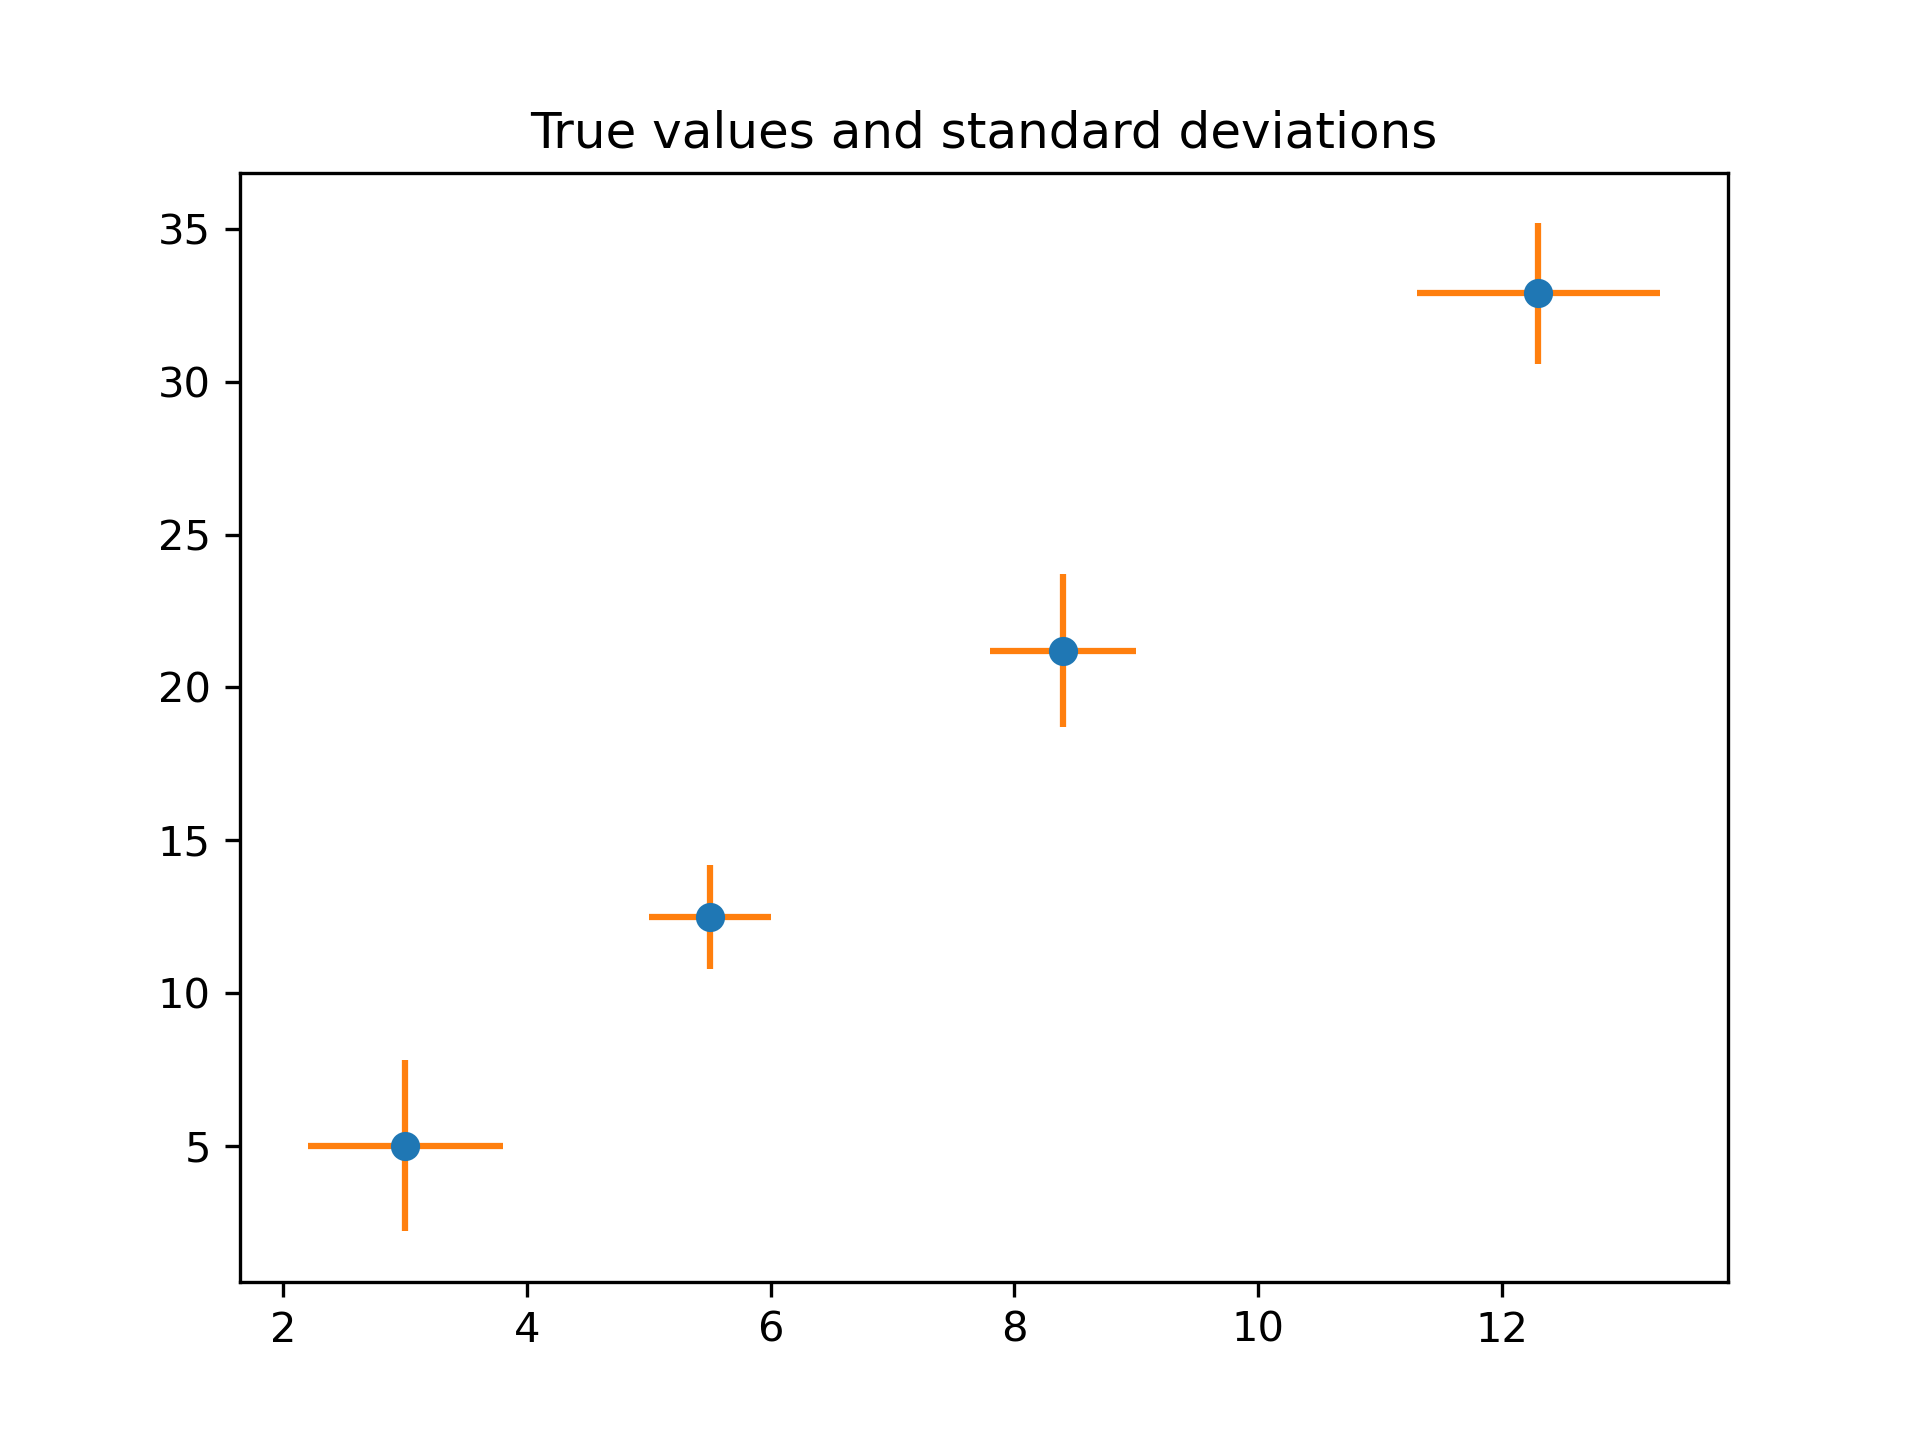

Text(0.5, 1.0, 'True values and standard deviations')

In [4]:
# Let's visualize the true data
plt.figure()
plt.plot(true_x, true_y, 'o')
plt.errorbar(true_x, true_y, xerr=true_sx, yerr=true_sy, ls='none')
plt.title('True values and standard deviations')

Now we "take the data." We will use the true values and standard deviations to simulate ten trials at each data point.

In [5]:
ntrials = 10
datax_meas = true_x.reshape(-1, 1) + true_sx.reshape(-1, 1) * np.random.randn(len(true_x), ntrials)
datay_meas = true_y.reshape(-1, 1) + true_sy.reshape(-1, 1) * np.random.randn(len(true_y), ntrials)

Plot the measured data. Colors correspond to repeated measurements of the same value.

<IPython.core.display.Javascript object>


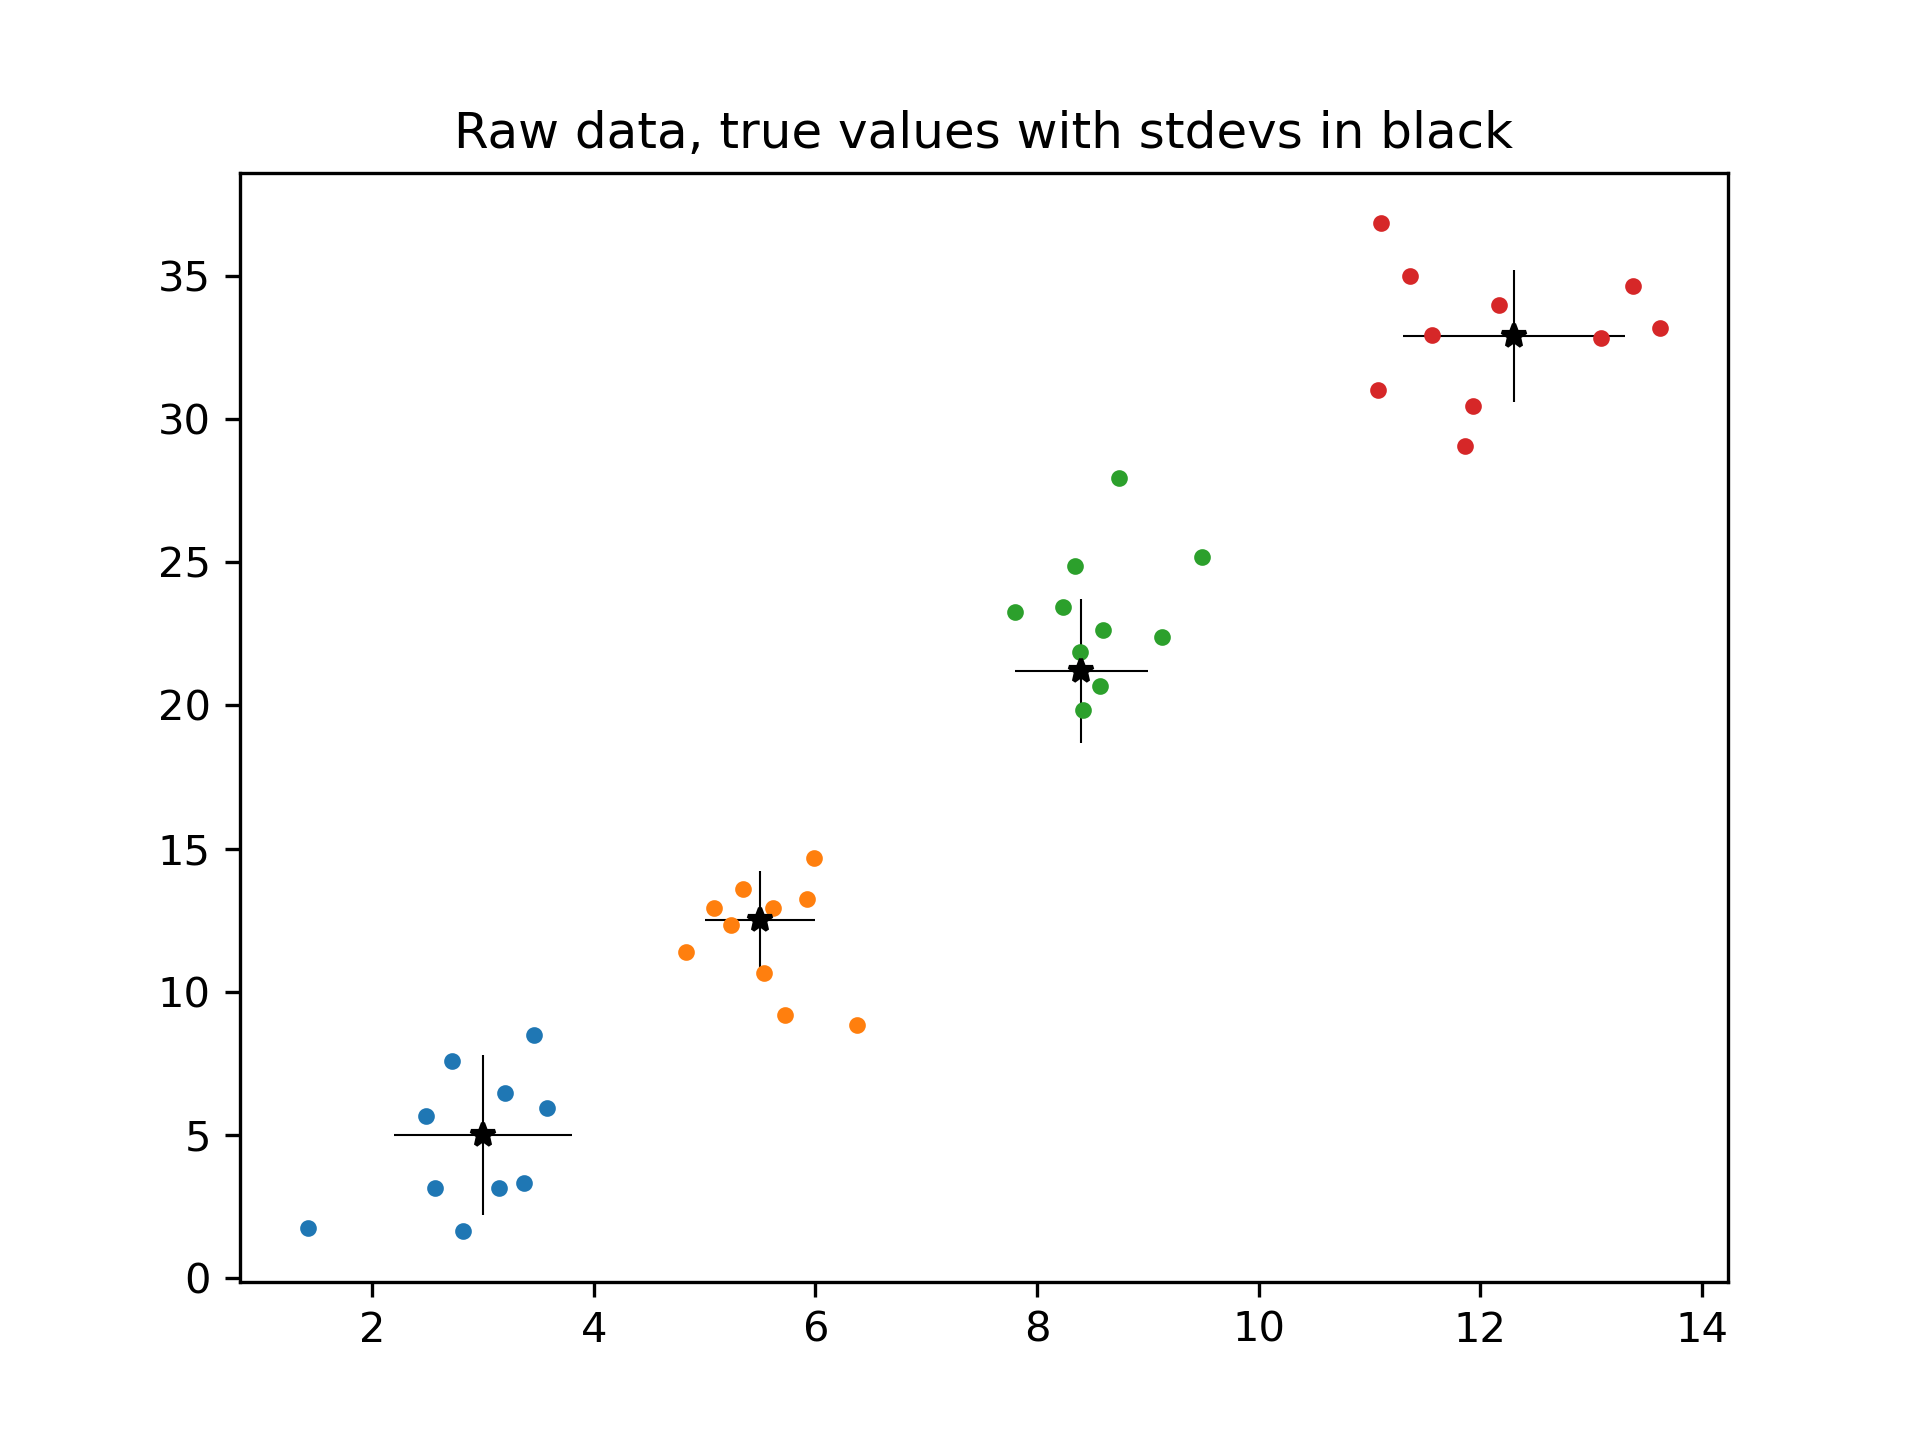

Text(0.5, 1.0, 'Raw data, true values with stdevs in black')

In [6]:
plt.figure()
for i in range(len(true_x)):
    plt.plot(datax_meas[i, :], datay_meas[i, :], '.')
plt.plot(true_x, true_y, 'k*')
plt.errorbar(true_x, true_y, xerr=true_sx, yerr=true_sy, ls='none', ecolor='k', elinewidth=.5)
plt.title('Raw data, true values with stdevs in black')

## Data Analysis

From here on out, we have our measured data, but we do not know the true values. We will compare to the true at the very end.

First we find the best estimate and uncertainty for each measurement. In other words, we combine all the blue, all the orange, etc in the plot above.

In [7]:
x_mean = np.mean(datax_meas, axis=1)
sx_meas = np.std(datax_meas, axis=1, ddof=1)
sx_mean = sx_meas / np.sqrt(ntrials)
y_mean = np.mean(datay_meas, axis=1)
sy_meas = np.std(datay_meas, axis=1, ddof=1)
sy_mean = sy_meas / np.sqrt(ntrials)

<IPython.core.display.Javascript object>


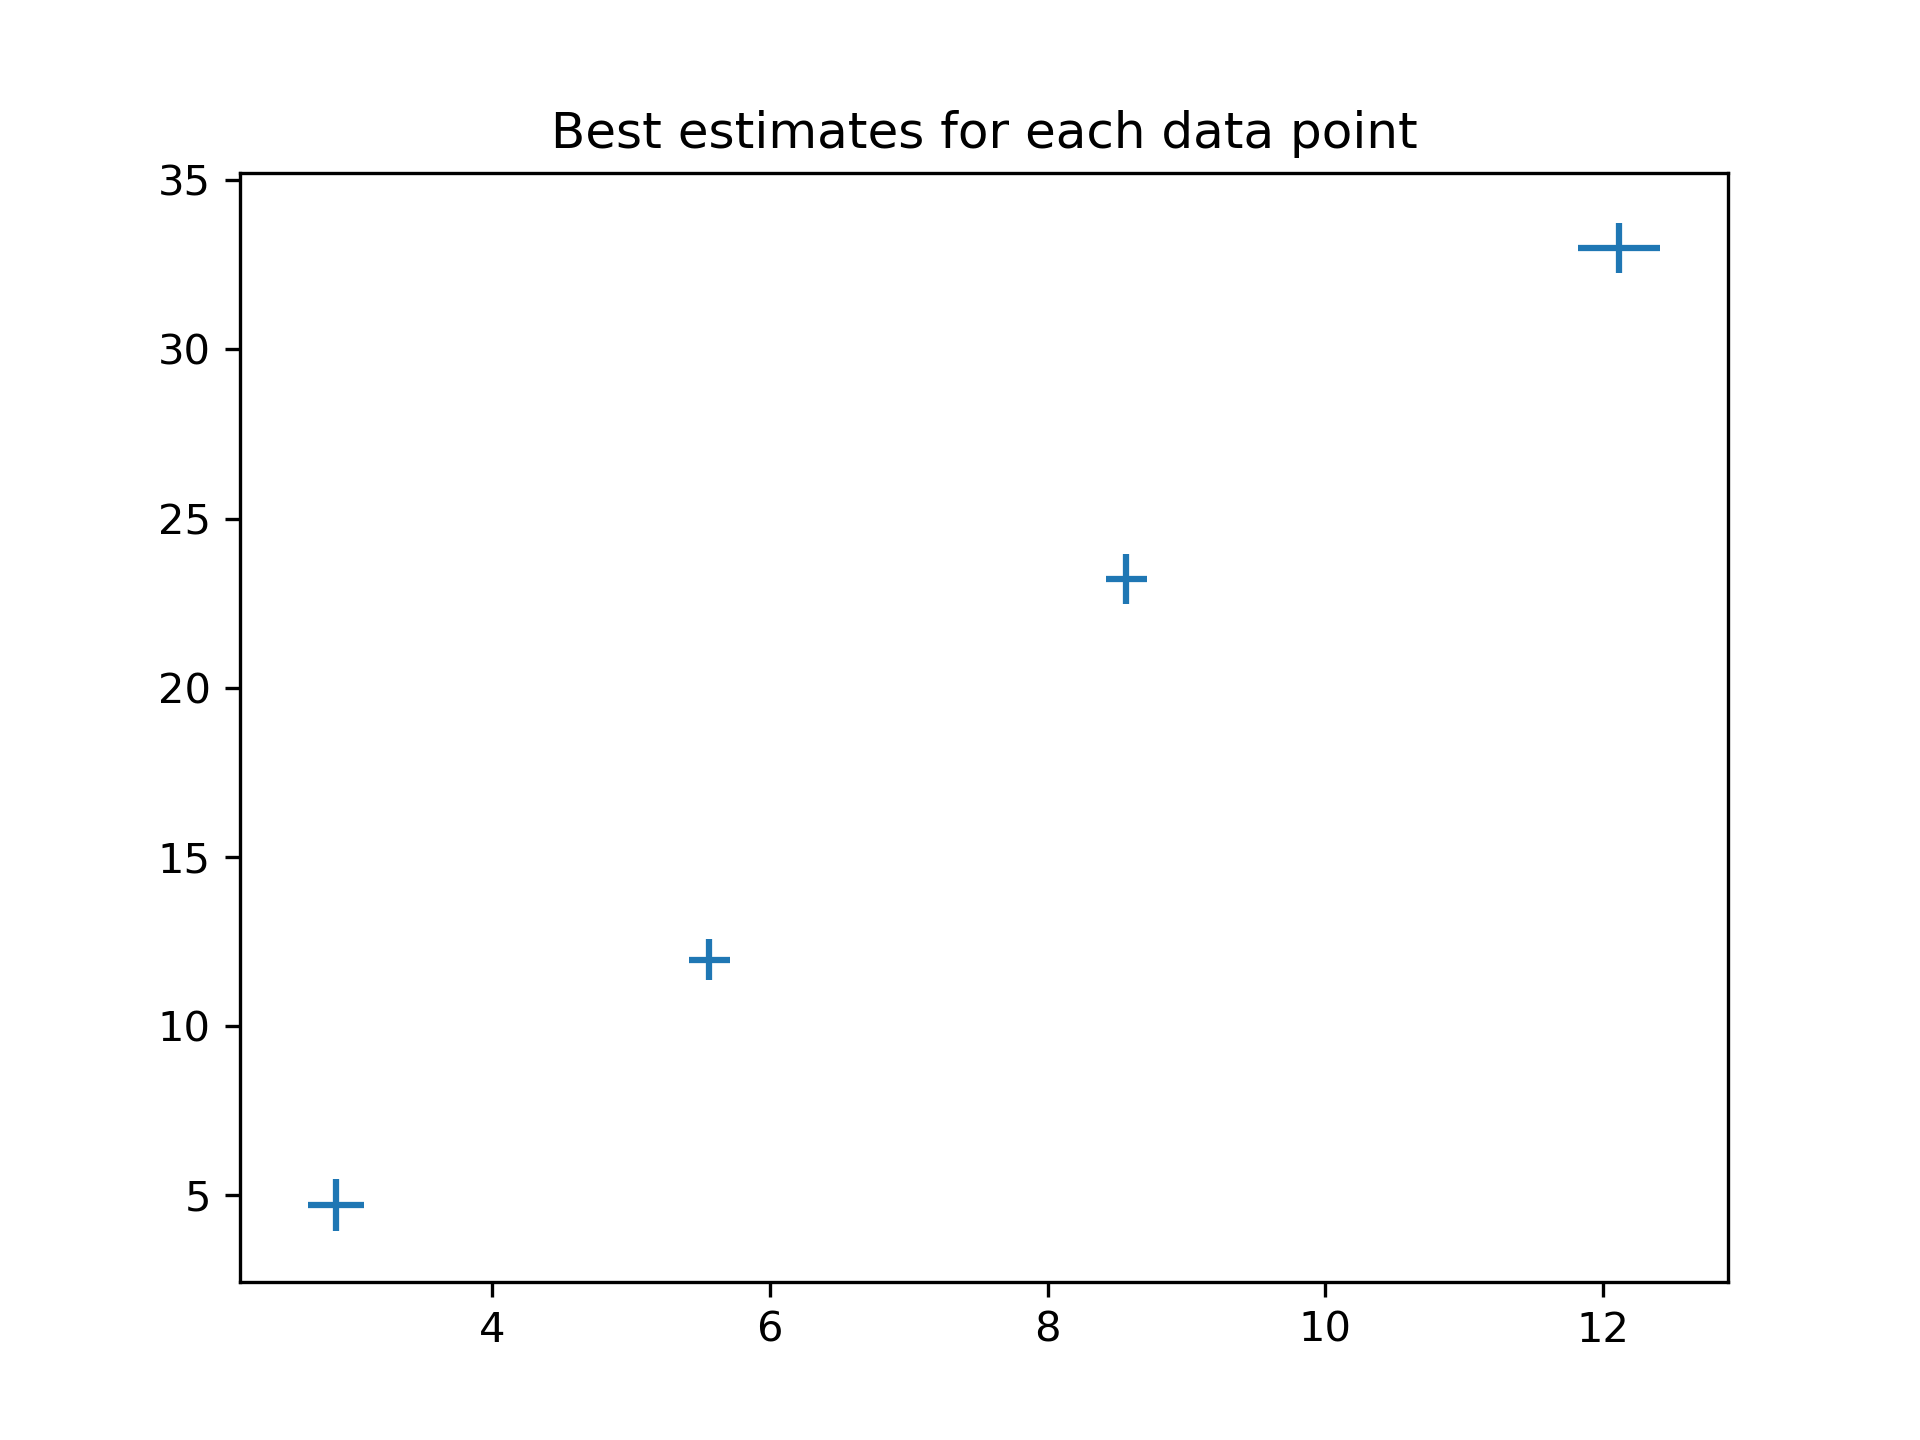

Text(0.5, 1.0, 'Best estimates for each data point')

In [8]:
plt.figure()
plt.errorbar(x_mean, y_mean, xerr=sx_mean, yerr=sy_mean, ls='none')
plt.title('Best estimates for each data point')

Here's where we need to fit the data to a line. We will use ODR, following the example here: https://docs.scipy.org/doc/scipy/reference/odr.html

In [9]:
linear = odr.Model(f)
mydata = odr.RealData(x_mean, y_mean, sx=sx_mean, sy=sy_mean)
myodr = odr.ODR(mydata, linear, beta0=[0, 0])
myoutput = myodr.run()

`pprint()` will print out all the results all pretty-like.
We can see the Beta values (fits to the model, this is the slope and intercept), the standard error on beta, and some other statistics on the fit. We don't need to copy-paste this into our code though. `myoutput` contains attributes with these values we can use, as in the plot below.

In [10]:
myoutput.pprint()

Beta: [ 3.17630517 -4.93513157]
Beta Std Error: [0.1783369  1.31966968]
Beta Covariance: [[ 0.0242142  -0.1641997 ]
 [-0.1641997   1.32592277]]
Residual Variance: 1.3134460735209168
Inverse Condition #: 0.05033460307978419
Reason(s) for Halting:
  Sum of squares convergence


## Compare with true values
Now we unmask the true values and compare with our results

<IPython.core.display.Javascript object>


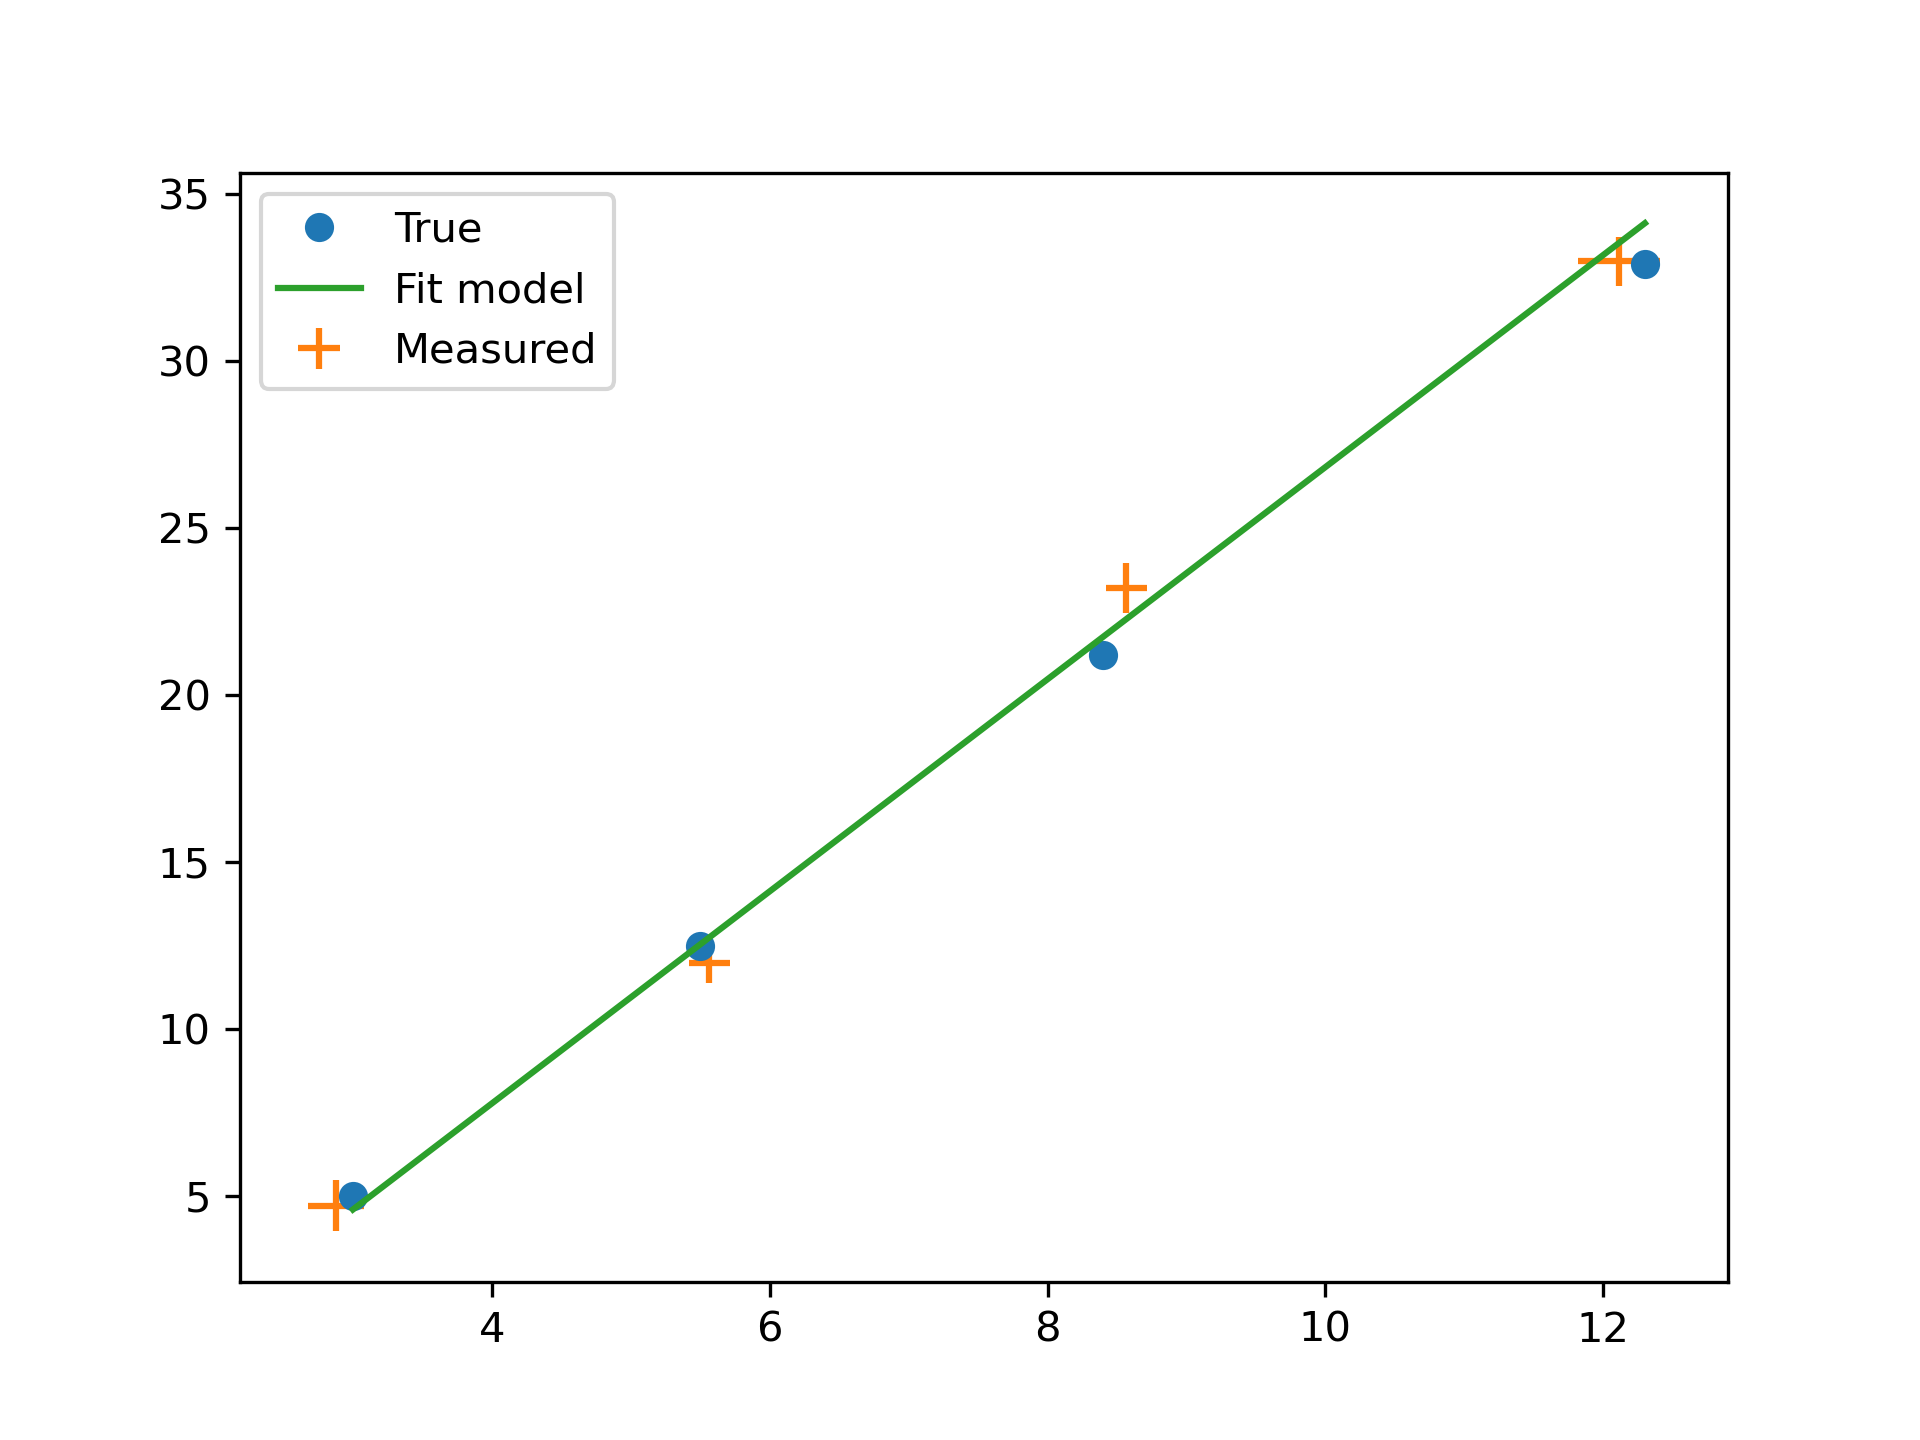

In [11]:
plt.figure()
plt.plot(true_x, true_y, 'o', label='True')
plt.errorbar(x_mean, y_mean, xerr=sx_mean, yerr=sy_mean, ls='none', label='Measured')
plt.plot(true_x, f(myoutput.beta, true_x), label='Fit model')
plt.legend()

In [12]:
# Discrepancy on the slope and intercept
slope_z = np.abs(true_slope - myoutput.beta[0]) / myoutput.sd_beta[0]
inter_z = np.abs(true_inter - myoutput.beta[1]) / myoutput.sd_beta[1]
print(f'Slope and intercept are within {slope_z:.2f} and {inter_z:.2f} sigma, respectively.')

Slope and intercept are within 0.99 and 0.71 sigma, respectively.
